In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the project files
# project folder, e.g. 'time series metric learning'
FOLDERNAME = 'time series metric learning'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
%cd drive/My\ Drive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/My Drive/time series metric learning


In [2]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, utils
import torch.nn.functional as F
from dataset import TimeSeriesDataset, BalancedBatchSampler
from data_utils import load_project_dataset, visualize_timeseries
from data_transformation import ToTensor, Normalize

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
USE_GPU = True

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    cuda=True
else:
    device = torch.device('cpu')
    cuda=False

print('using device:', device)

using device: cpu


Load the dataset

In [4]:
fname="./dataset/project_dataset.csv"
label_multi='Label_multi'
label_binary='Label_binary'
data, labels = load_project_dataset(fname,label_multi)

print("data.shape: ", data.shape)
print("labels.shape: ", labels.shape)

data.shape:  (2997, 4, 1, 1007)
labels.shape:  (2997,)


Plot class distribution

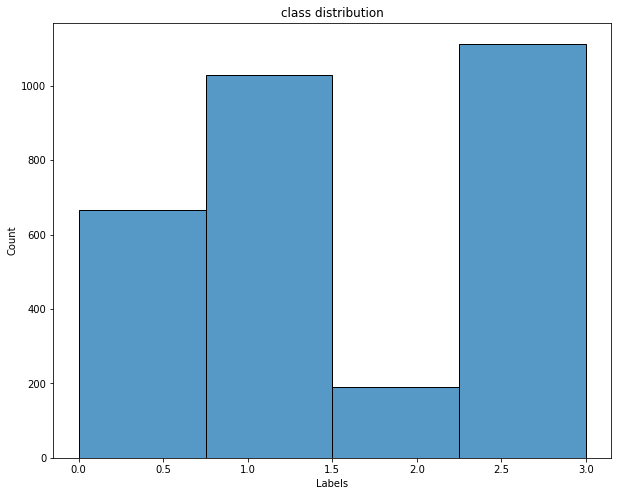

In [5]:
sns.histplot(labels, bins=4).set(title='class distribution');
plt.xlabel("Labels");

Visualize time series

0 (4, 1, 1007)
[[[-0.341831 -0.343865 -0.345492 ... -0.326073 -0.325958 -0.325867]]

 [[-0.264209 -0.264767 -0.265214 ...  0.326411  0.326229  0.324323]]

 [[-7.70879  -7.70829  -7.70789  ... -7.71205  -7.71154  -7.71203 ]]

 [[ 0.1146    0.1146    0.1146   ...  1.31613   1.31638   1.31705 ]]]
label: 3


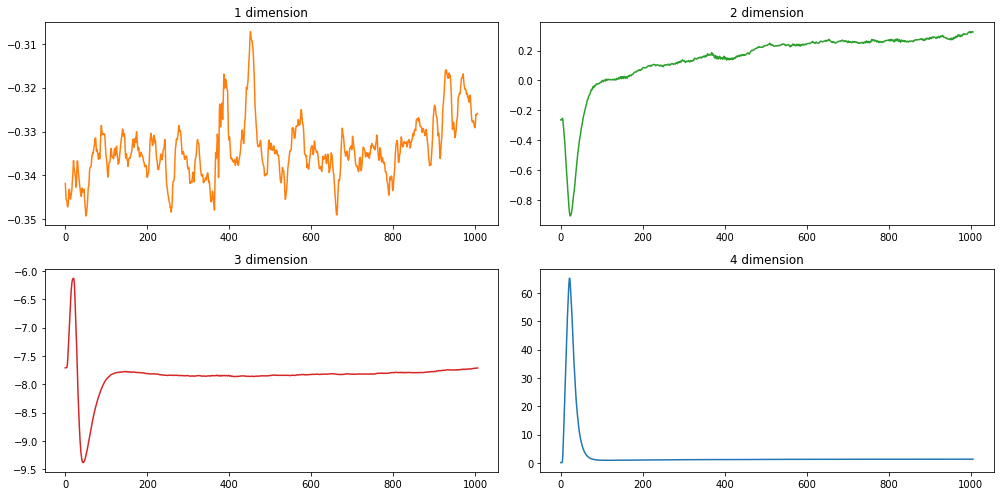

1 (4, 1, 1007)
[[[-0.268711  -0.271908  -0.273367  ... -0.355049  -0.355759  -0.355667 ]]

 [[-0.0751023 -0.0726618 -0.0700495 ...  0.477868   0.479634   0.487427 ]]

 [[-7.94819   -7.94616   -7.94474   ... -7.67414   -7.67283   -7.68194  ]]

 [[ 0.0916013  0.0916011  0.0916009 ...  1.39672    1.39552    0.353455 ]]]
label: 3


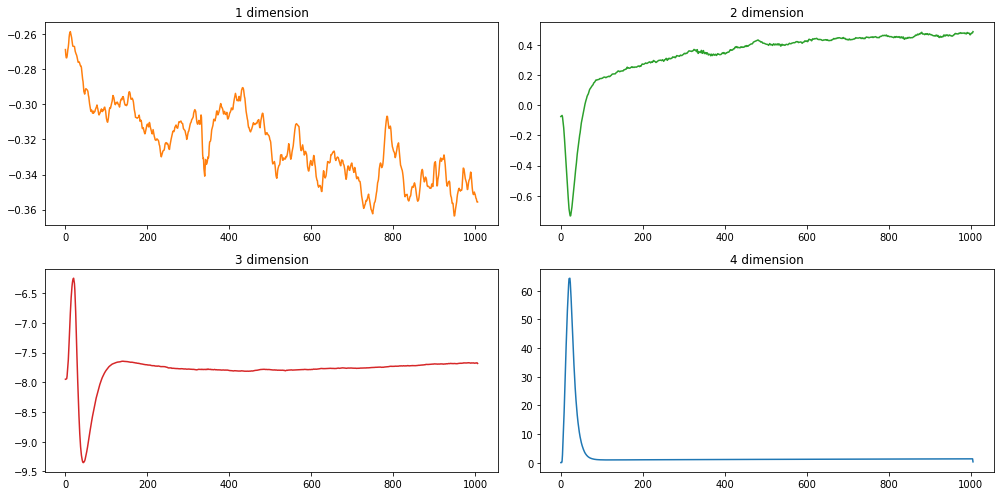

In [6]:
dataset = TimeSeriesDataset(data = data, train=True, labels=labels)
visualize_timeseries(dataset, 2)

Split the dataset in train/val/test

In [7]:
#ratio: 80/10/10
train_size=2400
test_size=300
val_size=297

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

print(" train_set: ",train_dataset.dataset.dataset[train_dataset.indices].shape)
print(" valid_set: ",valid_dataset.dataset.dataset[valid_dataset.indices].shape)
print(" test_set: ",test_dataset.dataset.dataset[test_dataset.indices].shape)

 train_set:  (2400, 4, 1, 1007)
 valid_set:  (297, 4, 1, 1007)
 test_set:  (300, 4, 1, 1007)


Compute statistichs on the training set

In [8]:
mean_train=()
std_train=()
dim=4

for i in range (0,dim):
  mean=np.mean(train_dataset.dataset.dataset[train_dataset.indices][:,i,:])
  std=np.std(train_dataset.dataset.dataset[train_dataset.indices][:,i,:])
  mean_train += (mean, )
  std_train += (std, )

print("per dimension(4) mean_train: ",mean_train)
print("per dimension(4) std_train: ",std_train)

per dimension(4) mean_train:  (-0.970247092811289, 1.8568396428215317, -8.630082663579943, 2.767329647724944)
per dimension(4) std_train:  (1.0292985678808206, 1.210710411650482, 0.4875044685812026, 7.82014631371647)


Define data transformation: ToTensor -> Normalize

0 torch.Size([4, 1, 1007])
tensor([[[-0.3022, -0.2961, -0.2926,  ..., -0.1552, -0.1546, -0.1540]],

        [[ 0.1339,  0.1366,  0.1365,  ...,  0.3776,  0.3785,  0.3793]],

        [[ 0.4621,  0.4643,  0.4625,  ..., -0.8781, -0.8780, -0.8780]],

        [[-0.3539, -0.3539, -0.3539,  ..., -0.1934, -0.1935, -0.1936]]],
       dtype=torch.float64)
label: tensor(1)


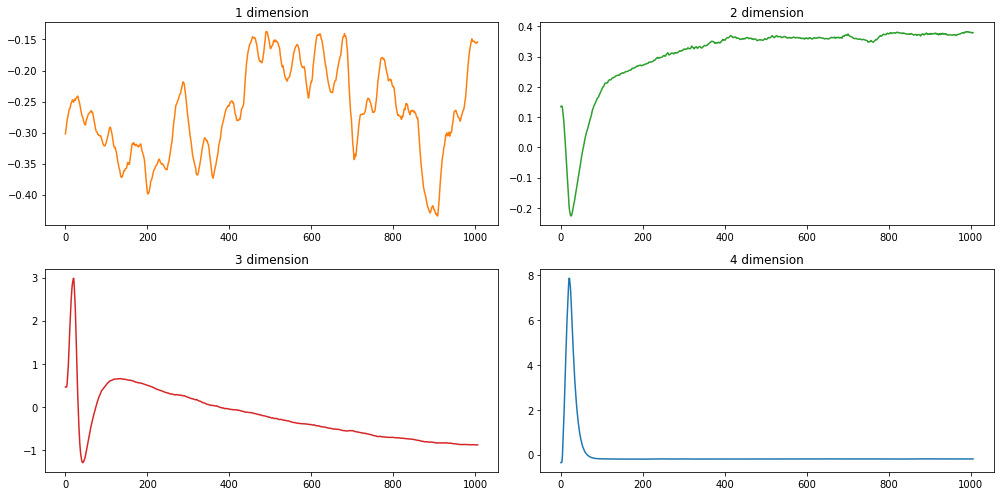

In [9]:
composed_transf = transforms.Compose([
                                    ToTensor(), #transform data and labels into tensors
                                    Normalize(mean_train, std_train),  #normalize each dimension
                                    ])


transformed_train_dataset = TimeSeriesDataset(data = train_dataset.dataset.dataset[train_dataset.indices], 
                                              labels = train_dataset.dataset.labels[train_dataset.indices], 
                                              transform = composed_transf, train=True)

transformed_valid_dataset = TimeSeriesDataset(data = valid_dataset.dataset.dataset[valid_dataset.indices], 
                                              labels = valid_dataset.dataset.labels[valid_dataset.indices], 
                                              transform = composed_transf, train=False)

transformed_test_dataset = TimeSeriesDataset(data = test_dataset.dataset.dataset[test_dataset.indices], 
                                              labels = test_dataset.dataset.labels[test_dataset.indices], 
                                              transform = composed_transf, train=False)

#visualize first element of transformed_train_dataset
visualize_timeseries(transformed_train_dataset, 1)

Sanity check the mean and std on the training set: should be mean=0 and std=1

In [10]:
dataloader_test_train = DataLoader(transformed_train_dataset, batch_size=1, shuffle=True)

prova = np.zeros((train_size, 4, 1, 1007))
jj=0

for i_batch, sample_batched in enumerate(dataloader_test_train):
    prova[jj]= sample_batched[0]
    jj+=1

    if i_batch <= 1:
      print("batch",i_batch, sample_batched[0].size(), sample_batched[1].size())

print("...")
print("Mean after normalization(should be near 0):", np.mean(prova))
print("Std after normalization (should be near 1):", np.std(prova))

batch 0 torch.Size([1, 4, 1, 1007]) torch.Size([1])
batch 1 torch.Size([1, 4, 1, 1007]) torch.Size([1])
...
Mean after normalization(should be near 0): 8.359431797702606e-16
Std after normalization (should be near 1): 1.0000000000000004


Plot some statistichs on the labels distribution in the 3 split

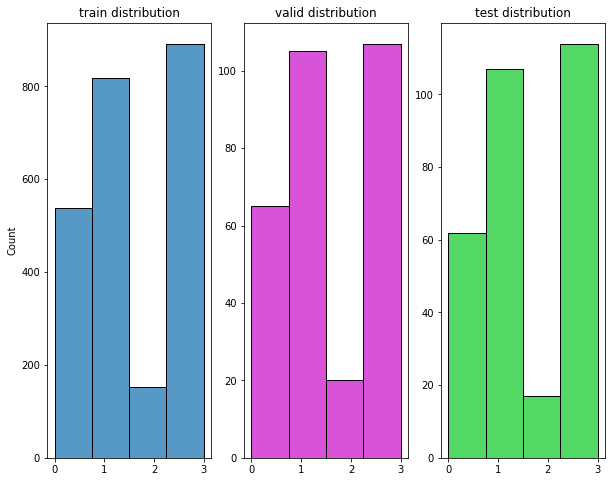

In [11]:
fig, axs = plt.subplots(ncols=3)
sns.histplot(transformed_train_dataset.labels, bins=4, ax=axs[0] ).set(title='train distribution');
sns.histplot(transformed_valid_dataset.labels, bins=4, color=(0.8, 0.1, 0.8), ax=axs[1] ).set(title='valid distribution');
sns.histplot(transformed_test_dataset.labels, bins=4,  color=(0.1, 0.8, 0.2), ax=axs[2]).set(title='test distribution');
axs[1] .set_ylabel(""); 
axs[2] .set_ylabel("");
